<a href="https://colab.research.google.com/github/mno-93/teaching/blob/main/AffectiveSignals_Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Affective signals IIII
----
<span style="color:Blue">**Through this notebook we hope you get an hands on approach to the seminar. 
    Below you will find code snippets and theory that will help you apply the various libraries that have been introduced to you in the course.**</span>

In [ ]:
! apt-get install cmake gfortran

In [ ]:
! pip install pyvhr

In [ ]:
! pip install --upgrade tensorflow
! pip install --upgrade tensorflow-gpu


In [ ]:
# mount your Google Drive, where your video is located

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pyVHR.signals.video import Video
from pyVHR.methods.pos import POS
from pyVHR.methods.chrom import CHROM
from pyVHR.analysis.testsuite import TestSuite, TestResult

In this Notebook we want to analyse heart rate related data from your prerecorded videos. Since we do not have ecg recordings, this will be estimated based on remote photoplethysmography (rPPG) using the [pVHR](https://github.com/phuselab/pyVHR) package. 

pyVHR stands for Python framework for Virtual Heart Rate and estimates beats per minute (bpm) by using the RGB-video data. A short overview of the framework is shown in the following figure. 

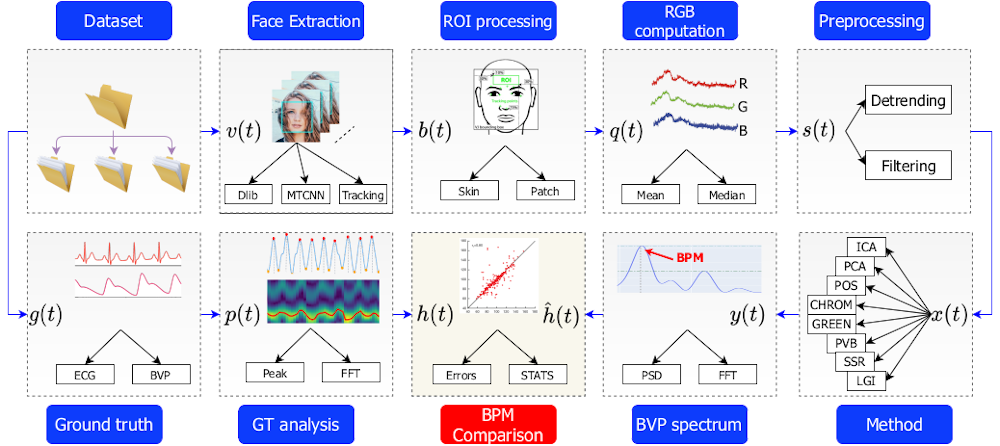



```
# This is formatted as code
```

First, we need to extract cropped face images from the video by using a pretrained face detection model: 

Additionally, you get some general information about your video file.

In [ ]:
from pyVHR.signals.video import Video

# -- Video object
videoFilename = "/content/drive/MyDrive/AffectiveSignals/video.mp4"
video = Video(videoFilename)

# -- extract faces
video.getCroppedFaces(detector='mtcnn', extractor='opencv')
video.printVideoInfo()


Visualize cropped face:


In [ ]:
print("\nShow video cropped faces, crop size:", video.cropSize)
video.showVideo()

In [ ]:
# -- define ROIs: standard regions, i.e. 'forehead', 'lcheek', 'rcheek', 'nose'
video.setMask(typeROI='rect', rectRegions=['forehead', 'lcheek', 'rcheek', 'nose'])
video.printROIInfo()
video.showVideo()

In [ ]:
# -- define ROIs: using skin, with threshold param 
video.setMask(typeROI='skin_adapt',skinThresh_adapt=0.2)
video.printROIInfo()
video.showVideo()

pyVHR calculates for every chunk based on RGB values the estimated BVP (blood volume pulse) and then bmp. 

Remote PPG measures the variance of red, green and blue light reflections changes from the skin (specular reflection and diffused reflection). 
Specular reflection is the light reflection from the skin surface, which is modulated by motion and skin surface itself. Diffuse reflection, in contrast, contains pulsatile information. It reflects absorbtion and scattering in skin tussue, which depends on blood volume changes. 
[Source](https://ieeexplore.ieee.org/abstract/document/7565547)

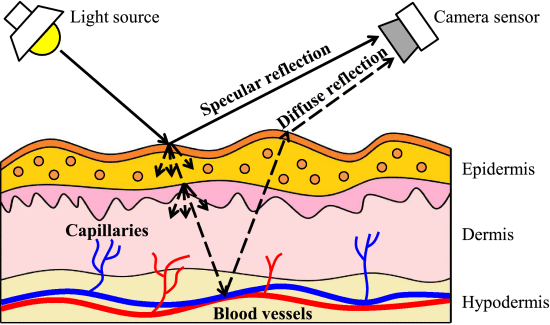


The framework uses different well-known rPPG methods to estimate the respective blood volume pulse from RGB values. 
First, the raw RGB data is preprocessed in order to suppress noise and artifacts. 

Then, the preprocessed signal is split into overlapped subsequences (chunks) in order to estimate a temporal sequence, the blood volume pulse (BVP), based on the respective rPPG method.

The BVP signal of the respective chunks is used to calculate bpm. Spectral analysis, in this case, Power Spectral Density (PSD) is performed to evaluate the power distribution as a function of frequency, hence to get the underlying bpm frequency.  




Apply different methods to compare the resulting difference in bpm estimation:

In [ ]:
# -- apply remote PPG method

from pyVHR.methods.pos import POS
from pyVHR.methods.ssr import SSR
from pyVHR.methods.pbv import PBV
from pyVHR.methods.chrom import CHROM
from pyVHR.methods.green import GREEN

# fine tuning
params = {"video": video, "verb":1, "ROImask":"skin_adapt", "skinAdapt":0.2}

# different methods
pos = POS(**params)
ssr = SSR(**params)
pbv = PBV(**params)
mchrom = CHROM(**params)
mgreen = GREEN(**params)

# -- get BPM values
bpmES_pos, timesES_pos = pos.runOffline(**params)
bpmES_pbv, timesES_pbv = pbv.runOffline(**params)
bpmES_green, timesES_green = mgreen.runOffline(**params)

bpmES_chrom, timesES_chrom = mchrom.runOffline(**params)

Visualize the different bpm estimation methods:

In [ ]:
print(f"The average heart rate is {np.average(bpmES_chrom[0])}")
plt.plot(timesES_chrom,bpmES_chrom[0][:])
plt.ylabel("BPM")
plt.xlabel("Time")
plt.title('Method - Chrom')

In [ ]:
print(f"The average heart rate is {np.average(bpmES_green[0])}")
plt.plot(timesES_green,bpmES_green[0][:])
plt.ylabel("BPM")
plt.xlabel("Time")
plt.title('Method - GREEN')

In [ ]:
print(f"The average heart rate is {np.average(bpmES_pos[0])}")
plt.plot(timesES_pos,bpmES_pos[0][:])
plt.ylabel("BPM")
plt.xlabel("Time")
plt.title('Method - POS')

In [ ]:
print(f"The average heart rate is {np.average(bpmES_pbv[0])}")
plt.plot(timesES_pos,bpmES_pbv[0][:])
plt.ylabel("BPM")
plt.xlabel("Time")
plt.title('Method - PVB')

calculate chunks, and append to get whole data

In [ ]:
# the code will be optimized depending on the chosen method
from pyVHR.utils import filters
from pyVHR.utils import printutils
from pyVHR.signals import bvp

verb = params['verb']
startTime = 0
endTime=np.Inf
winSize = 5
timeStep = 1
zeroMeanSTDnorm = 0
BPfilter = 1
minHz = .75
maxHz = 4.
detrending = 0
detrLambda = 10
detrMethod = 'tarvainen'

fs = video.frameRate

# -- check times
if endTime > video.duration:
    endTime = video.duration
assert startTime <= endTime, "Time interval error!"
assert timeStep > 0, "Time step must be positive!"
assert winSize < (endTime-startTime),"Winsize too big!"

timeSteps = np.arange(startTime,endTime,timeStep)
T = startTime    # times where bpm are estimated
RADIUS = winSize/2

bpmES = []     # bmp estimtes
timesES = []   # times of bmp estimtes

# -- loop on video signal chunks
startFrame = int(T*video.frameRate)
count = 0

bvpChunks = []
xChunks = []

while T <= endTime:
  endFrame = np.min([video.numFrames, int((T+RADIUS)*video.frameRate)])

  # -- extract ROIs on the frame range
  frameSubset = np.arange(startFrame, endFrame)

  ROImask = params['ROImask']

  # -- type of signal extractor
  if ROImask == 'rect':
      rects = ast.literal_eval(params['rectCoords'])
      rectCoords = []
      for x in rects:
          rect = []
          for y in x:
              rect.append(int(y))
          rectCoords.append(rect)
      video.setMask(ROImask, rectCoords=rectCoords)
  elif ROImask == 'skin_adapt':
      video.setMask(ROImask, skinThresh_adapt=float(params['skinAdapt']))
  elif ROImask == 'skin_fix':
      threshs = ast.literal_eval(params['skinFix'])
      threshSkinFix = [int(x) for x in threshs]
      video.setMask(ROImask, skinThresh_fix=threshSkinFix)
  else:
      raise ValueError(ROImask + " : Unimplemented Signal Extractor!")

  video.extractSignal(frameSubset, count)

  # -- RGB computation
  RGBsig = video.getMeanRGB()

  # -- print RGB raw data
  #if '2' in str(self.verb):
  #printutils.multiplot(y=RGBsig, name=['ch B', 'ch R','ch G'], title='RGB raw data')

  # -- RGBsig preprocessing
  if BPfilter:
      RGBsig = filters.BPfilter(RGBsig, minHz, maxHz, fs)

  # -- print postproce
  #if '2' in str(self.verb):
  #printutils.multiplot(y=RGBsig, name=['ch B', 'ch R','ch G'], title='RGB postprocessing')

  # -- apply the selected method to estimate BVP
  # use method selected
  rPPG = GREEN.apply(_, RGBsig)
              
  # BVP postprocessing 
  startTime = np.max([0, T-winSize/video.frameRate])
  bvpChunk = bvp.BVPsignal(rPPG, video.frameRate, startTime, minHz, maxHz, verb)
  print(bvpChunk.data.shape)

  # -- post processing: filtering
  #if '2' in str(self.verb):
  #bvpChunk.plot(title='BVP estimate by method')

  bvpChunk.plotBPMPeaks()

  c,n = bvpChunk.data.shape
  stopTime = bvpChunk.startTime+n/bvpChunk.fs
  x = np.linspace(bvpChunk.startTime, stopTime, num=n, endpoint=False)
  #print(x)

  # -- estimate BPM by PSD
  bvpChunk.PSD2BPM(chooseBest=True)

  #bvpChunk.spectrogram()

  # -- save the estimate
  bpmES.append(bvpChunk.bpm)
  timesES.append(T)

  # -- define the frame range for each time step            
  T += timeStep
  startFrame = np.max([0, int((T-RADIUS)*video.frameRate)])

  count += 1
  xChunks.append(x)
  bvpChunks.append(bvpChunk)


bpm = np.array(bpmES).T
# won't work since overlapping
#bvp = np.concatenate(bvpChunks, axis=1)

Pulse Rate Variability

In [ ]:
# calculate inter-pulse-intervalls
bvp_peakTimes = []
for i in range(0, len(data_chunks)):
  c,n = data_chunks[i].data.shape
  stopTime = data_chunks[i].startTime+n/data_chunks[i].fs
  x = np.linspace(data_chunks[i].startTime, stopTime, num=n, endpoint=False)
  bvp_peakTimes.append(x[data_chunks[i].peaks])
  print(bvp_peakTimes)

bvp_peakTimes = np.concatenate(bvp_peakTimes).ravel()
import collections
# take duplicates from peak estimation
b = [item for item, count in collections.Counter(bvp_peakTimes).items() if count > 1]

# inter pulse interval
ipi  = [x - b[i - 1] for i, x in enumerate(b)][1:]

In [ ]:
# Visualize PP intervals
plt.plot(ipi)
plt.xlabel('Time')
plt.ylabel('PP-Interval (sec)')
plt.title('PP Intervals')

In [ ]:
# calculate bpm from bvp

from scipy.signal import find_peaks, stft, lfilter, butter, welch

# -- interpolation for less than 256 samples
c,n = bvpChunk.data.shape
if n < 256:
    seglength = n
    overlap = int(0.8*n)  # fixed overlapping
else:
    seglength = 256
    overlap = 200

# -- periodogram by Welch
F, P = welch(bvpChunk.data, nperseg=seglength, noverlap=overlap, window='hamming',fs=bvpChunk.fs, nfft=bvpChunk.nFFT)

# -- freq subband (0.75 Hz - 4.0 Hz)
band = np.argwhere((F > bvpChunk.minHz) & (F < bvpChunk.maxHz)).flatten()
bvpChunk.Pfreqs = 60*F[band]
bvpChunk.Power = P[:,band]

In [ ]:
# Power Spectral Density (PSD)- Welch's Periodogram
# look for most frequent frequency --> 53
plt.plot(bvpChunk.Pfreqs,bvpChunk.Power[0])

In [ ]:
# -- BPM estimate by PSD
Pmax = np.argmax(bvpChunk.Power, axis=1)  # power max
bvpChunk.bpm = bvpChunk.Pfreqs[Pmax]       # freq max

In [ ]:
# -- if c = 3 choose that with the best SNR
if chooseBest:
    winner = 0
    lobes = bvpChunk.PDSrippleAnalysis(ch=0)
    SNR = lobes[-1]/lobes[-2]
    if c == 3:
        lobes = bvpChunk.PDSrippleAnalysis(ch=1)
        SNR1 = lobes[-1]/lobes[-2]
        if SNR1 > SNR:
            SNR = SNR1
            winner = 1
        lobes = bvpChunk.PDSrippleAnalysis(ch=2)
        SNR1 = lobes[-1]/lobes[-2]
        if SNR1 > SNR:
            SNR = SNR1
            winner = 2    
    bvpChunk.Power = bvpChunk.Power[winner].reshape(1,-1)


# -- BPM estimate by PSD
Pmax = np.argmax(bvpChunk.Power, axis=1)  # power max
bvpChunk.bpm = bvpChunk.Pfreqs[Pmax]       # freq max

In [ ]:
# last chunk
bvpChunk.plot()

In [ ]:
bvpChunk.plotBPMPeaks()

In [ ]:
bvpChunk.displayPSD()